In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [55]:
update_stocks()

Updated 2020-04-10, max actual date: 2020-04-09 00:00:00


In [56]:
all_files = os.listdir('data/')
print(f'no of all available files: {len(all_files)}')

no of all available files: 1957


In [57]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [58]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [59]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

## One one paper

In [61]:
[a for a in all_files if 'MOB' in a]

['IMMOBILE.mst']

In [62]:
papier = 'NEUCA'

In [63]:
#plot_paper(papier,'2008-07-15','2008-11-15')

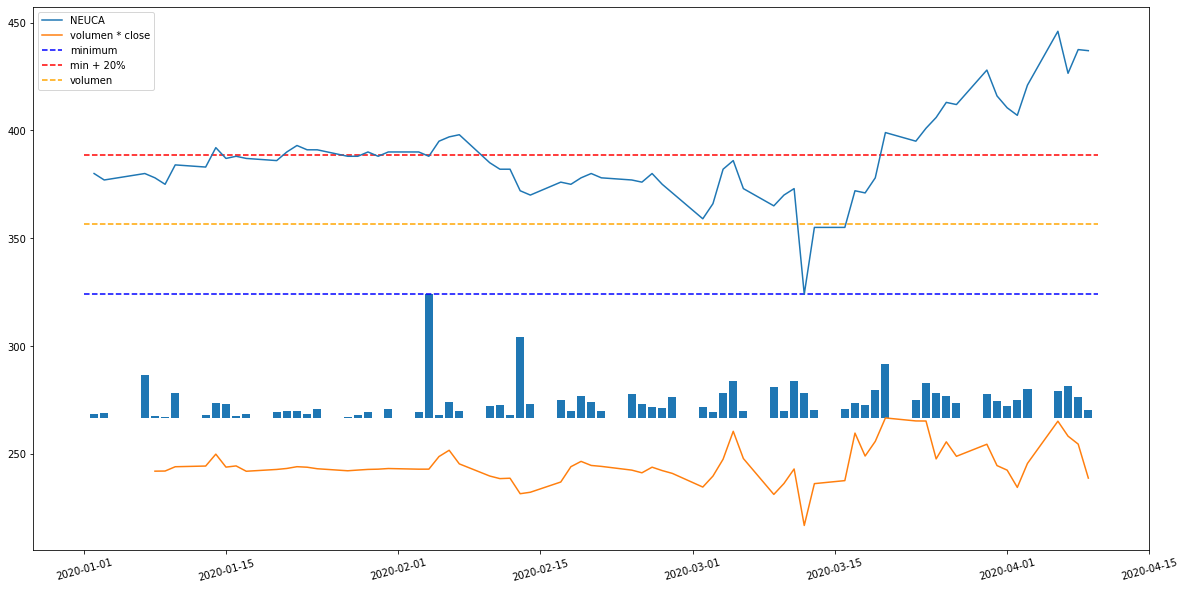

In [66]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [67]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [68]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: NEUCA, currently at 437.0, with potential -8.92% to top
Max before crisis: 398.0
Crisis bottom: 324.0
Max after crisis drop: 446.0, at 2020-04-06 00:00:00
Stats after Max: [446.  426.5 437.5 437. ]


## Skaner

In [69]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [70]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:16<00:00, 116.65it/s]


In [71]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)


In [74]:
skaner_df_see = skaner_df.loc[
    (skaner_df.growth_quarter > 0) 
        & (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 20)
                              ,:].sort_values('drop_current', ascending=True)

In [75]:
skaner_df_see.sort_values('growth_current', ascending=False).dropna()

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,BIOMEDLUB,3.4900,1.100,0.950,0.838,0.580,5.000,1.250,15.79,13.37,762.07,501.72,-64.18,179.20
0,RCFL4CDPRO,38.0500,70.000,25.970,16.850,9.730,38.050,73.000,169.54,54.12,291.06,291.06,91.85,-47.88
0,RCFL3CDPRO1,70.4500,96.200,41.880,29.260,24.480,70.450,96.200,129.70,43.13,187.79,187.79,36.55,-26.77
0,LUBAWA,1.1900,0.818,0.808,0.620,0.510,1.560,0.896,1.24,30.32,205.88,133.33,-24.71,32.81
0,INTLGLD23069,164.3000,119.100,92.450,34.340,74.650,164.300,120.700,28.83,169.22,120.09,120.09,-26.54,36.12
0,RCFL3SILVE,2.9200,4.920,4.900,3.200,1.440,2.920,5.480,0.41,53.12,102.78,102.78,87.67,-46.72
0,RCFL5GOLD,22.1000,17.550,14.350,8.400,12.180,22.100,17.910,22.30,70.83,81.44,81.44,-18.96,23.39
0,PLAYWAY,345.0000,380.000,187.000,169.600,197.000,358.000,380.000,103.21,10.26,81.73,75.13,10.14,-9.21
0,RAINBOW,10.4000,35.900,27.000,21.700,5.940,12.300,37.500,32.96,24.42,107.07,75.08,260.58,-72.27
0,INTLGLD09746,199.4000,156.300,128.100,69.000,114.100,200.000,157.200,22.01,85.65,75.28,74.76,-21.16,26.84


In [87]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x)| ('INTLGLD' in x) else True).values,]

In [88]:
skaner_df_see

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,RAINBOW,10.4000,35.900,27.000,21.700,5.940,12.300,37.500,32.96,24.42,107.07,75.08,260.58,-72.27
0,ENTER,19.9500,51.400,38.200,32.700,14.000,20.000,52.600,34.55,16.82,42.86,42.50,163.66,-62.07
0,GETIN,0.9305,1.574,1.112,1.074,0.750,1.062,1.868,41.55,3.54,41.60,24.07,100.75,-50.19
0,AMREST,24.8500,47.700,44.750,38.400,18.500,24.850,49.150,6.59,16.54,34.32,34.32,97.79,-49.44
0,GRODNO,3.9900,7.100,4.140,3.800,2.800,3.990,7.300,71.50,8.95,42.50,42.50,82.96,-45.34
0,SETANTA,7.3800,13.100,4.840,1.770,5.980,8.540,13.100,170.66,173.45,42.81,23.41,77.51,-43.66
0,SUNEX,8.6000,13.900,8.800,5.640,5.000,8.600,15.000,57.95,56.03,72.00,72.00,74.42,-42.67
0,JWWINVEST,2.4700,3.630,1.750,1.070,1.700,2.700,4.200,107.43,63.55,58.82,45.29,70.04,-41.19
0,UNIMOT,20.0000,30.000,24.700,14.200,13.000,20.500,33.000,21.46,73.94,57.69,53.85,65.00,-39.39
0,MLSYSTEM,24.8000,36.900,22.900,20.500,17.200,24.800,38.500,61.14,11.71,44.19,44.19,55.24,-35.58


### WIG

In [84]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 50/50 [00:00<00:00, 141.45it/s]


In [85]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)


In [86]:
skaner_wig_df_see = skaner_wig_df.loc[(skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [87]:
skaner_wig_df.sort_values('growth_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RCLMWIG40AOPEN,29.15,NaN,NaN,NaN,29.15,29.15,39.31,NaN,NaN,0.00,0.00,-25.85
0,SWIG80DVP,0.94,NaN,371.67,97.65,0.94,0.94,410.71,NaN,280.61,0.00,0.00,-99.77
0,WIG-BANKI,3931.74,6852.02,7073.65,7513.37,3931.74,4406.52,7327.60,-3.13,-5.85,12.08,0.00,-46.34
0,MWIG40DVP,0.57,0.57,110.86,38.96,0.57,0.57,117.22,-99.49,184.55,0.00,0.00,-99.51
0,WIG-NRCHOM,1834.45,2610.21,2288.28,2110.54,1834.45,2132.56,2610.21,14.07,8.42,16.25,0.00,-29.72
0,RCBMWIG401121,748.10,NaN,NaN,NaN,748.10,748.10,1005.60,NaN,NaN,0.00,0.00,-25.61
0,RCFS2MWIG40,20.29,NaN,NaN,NaN,20.29,20.29,NaN,NaN,NaN,0.00,0.00,NaN
0,WIG20SHORT,4943.90,3696.44,3633.11,3490.73,4925.06,5623.80,3826.33,1.74,4.08,14.19,0.38,29.21
0,WIG.MS-FIN,6130.43,10041.71,10343.27,11200.03,6047.16,6612.93,10700.18,-2.92,-7.65,9.36,1.38,-42.71
0,MWIG40TR,3722.18,5299.43,4779.99,5029.64,3603.52,3869.21,5339.13,10.87,-4.96,7.37,3.29,-30.28


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

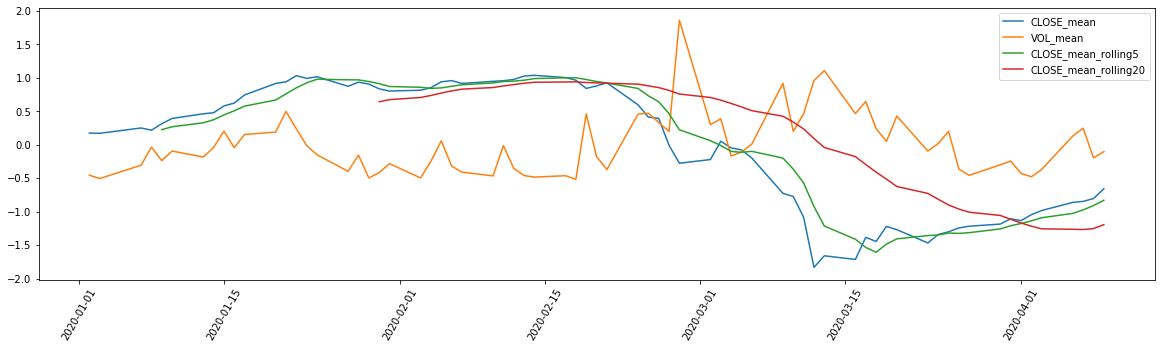

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [97]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [55]:
def transform_one_paper(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    #df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    df.loc[:, 'target'] = np.nan
    df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
    df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    return df

In [294]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'chng_OPEN_CLOSE'] = (df.loc[:,'CLOSE'] * 100 / df.loc[:,'OPEN']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
       
    df.loc[df.loc[:, 'LOW'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 1
    df.loc[df.loc[:, 'LOW'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 0
    
    df.loc[df.loc[:, 'HIGH'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'] > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN'] = 1
    df.loc[df.loc[:, 'OPEN'] <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN'] = 0
    
    df.loc[:,'same_CLOSE_LOW'] = 0
    df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'LOW'],'same_CLOSE_LOW'] = 1
    df.loc[:,'same_CLOSE_HIGH'] = 0
    df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'HIGH'],'same_CLOSE_HIGH'] = 1
    
    df.loc[:,'same_OPEN_LOW'] = 0
    df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'LOW'],'same_OPEN_LOW'] = 1
    df.loc[:,'same_OPEN_HIGH'] = 0
    df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'HIGH'],'same_OPEN_HIGH'] = 1
    
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0

    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    

    
    #historic features

#     for a in [c for c in df.columns if ('chng_' in c) | ('move_' in c) | ('comp_' in c)]:
#         for i in [1, 2, 3, 4, 5]:
#             df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('comp_' in c) 
                                        | ('diff_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()


    df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0
    
    #df.loc[:, 'target'] = df.loc[:,'diff_LOW_HIGH'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0

#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'], 'target'] = 0
    
#     df.loc[:, 'target'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target'] = df.loc[:, 'chng_OPEN'].shift(-1)
#     df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    return df

In [295]:
store_dict = dict()

In [296]:
df_merged = pd.DataFrame()

if 'store_dict' not in locals():
    store_dict = dict()

for p in tqdm(skaner_df_see.ticker.values):
    
    try:
        df = store_dict[p].copy()
        
    except:
        df = prepare_data(p) 
        store_dict[p] = df.copy()
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


In [394]:
df = df_merged.copy()

#df_merged.loc[:, ['TICKER','bin_OPEN']].iloc[125:200,:].groupby('TICKER').shift(1)
#df_merged.loc[:, 'target'] = df_merged.loc[:, 'bin_OPEN'].shift(-1)

train_cols = [c for c in df.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c)]

In [395]:
#train_cols = train_cols_limited

cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [396]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC')

# # # Initialize CatBoostClassifier
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [397]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.6998501	best: 0.6998501 (0)	total: 17.6ms	remaining: 35.1s
1:	test: 0.7061668	best: 0.7061668 (1)	total: 34.5ms	remaining: 34.5s
2:	test: 0.7064315	best: 0.7064315 (2)	total: 51.1ms	remaining: 34s
3:	test: 0.7137077	best: 0.7137077 (3)	total: 67.4ms	remaining: 33.6s
4:	test: 0.7189162	best: 0.7189162 (4)	total: 83.8ms	remaining: 33.5s
5:	test: 0.7186871	best: 0.7189162 (4)	total: 99.9ms	remaining: 33.2s
6:	test: 0.7182934	best: 0.7189162 (4)	total: 116ms	remaining: 33.1s
7:	test: 0.7185057	best: 0.7189162 (4)	total: 133ms	remaining: 33.1s
8:	test: 0.7198224	best: 0.7198224 (8)	total: 149ms	remaining: 33s
9:	test: 0.7193356	best: 0.7198224 (8)	total: 165ms	remaining: 32.9s
10:	test: 0.7206566	best: 0.7206566 (10)	total: 181ms	remaining: 32.7s
11:	test: 0.7219112	best: 0.7219112 (11)	total: 197ms	remaining: 32.7s
12:	test: 0.7220440	best: 0.7220440 (12)	total: 213ms	remaining: 32.6s
13:	test: 0.7218887	best: 0.7220440 (12)	total: 233ms	remaining: 33.1s
14:	test: 0.7218022	best

119:	test: 0.7456574	best: 0.7457418 (118)	total: 2.32s	remaining: 36.4s
120:	test: 0.7456490	best: 0.7457418 (118)	total: 2.35s	remaining: 36.4s
121:	test: 0.7456769	best: 0.7457418 (118)	total: 2.36s	remaining: 36.4s
122:	test: 0.7456646	best: 0.7457418 (118)	total: 2.38s	remaining: 36.3s
123:	test: 0.7456312	best: 0.7457418 (118)	total: 2.4s	remaining: 36.3s
124:	test: 0.7454701	best: 0.7457418 (118)	total: 2.42s	remaining: 36.2s
125:	test: 0.7455341	best: 0.7457418 (118)	total: 2.44s	remaining: 36.3s
126:	test: 0.7457053	best: 0.7457418 (118)	total: 2.46s	remaining: 36.2s
127:	test: 0.7456019	best: 0.7457418 (118)	total: 2.48s	remaining: 36.2s
128:	test: 0.7456019	best: 0.7457418 (118)	total: 2.49s	remaining: 36.1s
129:	test: 0.7457108	best: 0.7457418 (118)	total: 2.51s	remaining: 36.1s
130:	test: 0.7458278	best: 0.7458278 (130)	total: 2.52s	remaining: 36s
131:	test: 0.7459893	best: 0.7459893 (131)	total: 2.55s	remaining: 36.1s
132:	test: 0.7459041	best: 0.7459893 (131)	total: 2.57

235:	test: 0.7518397	best: 0.7518397 (235)	total: 4.4s	remaining: 32.9s
236:	test: 0.7518804	best: 0.7518804 (236)	total: 4.42s	remaining: 32.8s
237:	test: 0.7519758	best: 0.7519758 (237)	total: 4.43s	remaining: 32.8s
238:	test: 0.7520796	best: 0.7520796 (238)	total: 4.45s	remaining: 32.8s
239:	test: 0.7521237	best: 0.7521237 (239)	total: 4.46s	remaining: 32.7s
240:	test: 0.7522136	best: 0.7522136 (240)	total: 4.48s	remaining: 32.7s
241:	test: 0.7522962	best: 0.7522962 (241)	total: 4.5s	remaining: 32.7s
242:	test: 0.7524047	best: 0.7524047 (242)	total: 4.52s	remaining: 32.7s
243:	test: 0.7524585	best: 0.7524585 (243)	total: 4.54s	remaining: 32.7s
244:	test: 0.7524450	best: 0.7524585 (243)	total: 4.56s	remaining: 32.6s
245:	test: 0.7525357	best: 0.7525357 (245)	total: 4.57s	remaining: 32.6s
246:	test: 0.7525454	best: 0.7525454 (246)	total: 4.59s	remaining: 32.6s
247:	test: 0.7524899	best: 0.7525454 (246)	total: 4.61s	remaining: 32.6s
248:	test: 0.7526806	best: 0.7526806 (248)	total: 4.6

348:	test: 0.7572553	best: 0.7572667 (346)	total: 6.5s	remaining: 30.7s
349:	test: 0.7573608	best: 0.7573608 (349)	total: 6.52s	remaining: 30.7s
350:	test: 0.7573193	best: 0.7573608 (349)	total: 6.54s	remaining: 30.7s
351:	test: 0.7573498	best: 0.7573608 (349)	total: 6.55s	remaining: 30.7s
352:	test: 0.7573756	best: 0.7573756 (352)	total: 6.57s	remaining: 30.7s
353:	test: 0.7573689	best: 0.7573756 (352)	total: 6.59s	remaining: 30.7s
354:	test: 0.7573443	best: 0.7573756 (352)	total: 6.61s	remaining: 30.6s
355:	test: 0.7575058	best: 0.7575058 (355)	total: 6.63s	remaining: 30.6s
356:	test: 0.7575634	best: 0.7575634 (356)	total: 6.65s	remaining: 30.6s
357:	test: 0.7576757	best: 0.7576757 (357)	total: 6.67s	remaining: 30.6s
358:	test: 0.7577257	best: 0.7577257 (358)	total: 6.69s	remaining: 30.6s
359:	test: 0.7576914	best: 0.7577257 (358)	total: 6.71s	remaining: 30.6s
360:	test: 0.7576427	best: 0.7577257 (358)	total: 6.74s	remaining: 30.6s
361:	test: 0.7577126	best: 0.7577257 (358)	total: 6.

470:	test: 0.7597208	best: 0.7597208 (470)	total: 9.04s	remaining: 29.3s
471:	test: 0.7597568	best: 0.7597568 (471)	total: 9.05s	remaining: 29.3s
472:	test: 0.7597725	best: 0.7597725 (472)	total: 9.07s	remaining: 29.3s
473:	test: 0.7597924	best: 0.7597924 (473)	total: 9.1s	remaining: 29.3s
474:	test: 0.7598336	best: 0.7598336 (474)	total: 9.11s	remaining: 29.3s
475:	test: 0.7597971	best: 0.7598336 (474)	total: 9.13s	remaining: 29.2s
476:	test: 0.7597869	best: 0.7598336 (474)	total: 9.14s	remaining: 29.2s
477:	test: 0.7598052	best: 0.7598336 (474)	total: 9.16s	remaining: 29.2s
478:	test: 0.7598399	best: 0.7598399 (478)	total: 9.18s	remaining: 29.1s
479:	test: 0.7599645	best: 0.7599645 (479)	total: 9.19s	remaining: 29.1s
480:	test: 0.7599883	best: 0.7599883 (480)	total: 9.21s	remaining: 29.1s
481:	test: 0.7600251	best: 0.7600251 (481)	total: 9.22s	remaining: 29s
482:	test: 0.7600726	best: 0.7600726 (482)	total: 9.24s	remaining: 29s
483:	test: 0.7601442	best: 0.7601442 (483)	total: 9.26s	

589:	test: 0.7616426	best: 0.7616472 (580)	total: 11.1s	remaining: 26.5s
590:	test: 0.7616612	best: 0.7616612 (590)	total: 11.1s	remaining: 26.5s
591:	test: 0.7616934	best: 0.7616934 (591)	total: 11.1s	remaining: 26.5s
592:	test: 0.7617570	best: 0.7617570 (592)	total: 11.2s	remaining: 26.5s
593:	test: 0.7617112	best: 0.7617570 (592)	total: 11.2s	remaining: 26.4s
594:	test: 0.7617867	best: 0.7617867 (594)	total: 11.2s	remaining: 26.4s
595:	test: 0.7617951	best: 0.7617951 (595)	total: 11.2s	remaining: 26.4s
596:	test: 0.7618430	best: 0.7618430 (596)	total: 11.2s	remaining: 26.4s
597:	test: 0.7619329	best: 0.7619329 (597)	total: 11.2s	remaining: 26.4s
598:	test: 0.7619265	best: 0.7619329 (597)	total: 11.3s	remaining: 26.4s
599:	test: 0.7618875	best: 0.7619329 (597)	total: 11.3s	remaining: 26.3s
600:	test: 0.7620011	best: 0.7620011 (600)	total: 11.3s	remaining: 26.3s
601:	test: 0.7619808	best: 0.7620011 (600)	total: 11.3s	remaining: 26.3s
602:	test: 0.7619952	best: 0.7620011 (600)	total: 1

706:	test: 0.7633710	best: 0.7634223 (705)	total: 13.2s	remaining: 24.1s
707:	test: 0.7633596	best: 0.7634223 (705)	total: 13.2s	remaining: 24.1s
708:	test: 0.7633710	best: 0.7634223 (705)	total: 13.2s	remaining: 24.1s
709:	test: 0.7633982	best: 0.7634223 (705)	total: 13.3s	remaining: 24.1s
710:	test: 0.7634037	best: 0.7634223 (705)	total: 13.3s	remaining: 24.1s
711:	test: 0.7634325	best: 0.7634325 (711)	total: 13.3s	remaining: 24.1s
712:	test: 0.7634249	best: 0.7634325 (711)	total: 13.3s	remaining: 24s
713:	test: 0.7634761	best: 0.7634761 (713)	total: 13.3s	remaining: 24s
714:	test: 0.7634740	best: 0.7634761 (713)	total: 13.3s	remaining: 24s
715:	test: 0.7635156	best: 0.7635156 (715)	total: 13.4s	remaining: 24s
716:	test: 0.7635134	best: 0.7635156 (715)	total: 13.4s	remaining: 23.9s
717:	test: 0.7635982	best: 0.7635982 (717)	total: 13.4s	remaining: 23.9s
718:	test: 0.7635872	best: 0.7635982 (717)	total: 13.4s	remaining: 23.9s
719:	test: 0.7635885	best: 0.7635982 (717)	total: 13.4s	rem

822:	test: 0.7643234	best: 0.7643234 (822)	total: 15.3s	remaining: 21.9s
823:	test: 0.7643641	best: 0.7643641 (823)	total: 15.3s	remaining: 21.9s
824:	test: 0.7643497	best: 0.7643641 (823)	total: 15.3s	remaining: 21.8s
825:	test: 0.7643302	best: 0.7643641 (823)	total: 15.4s	remaining: 21.8s
826:	test: 0.7643934	best: 0.7643934 (826)	total: 15.4s	remaining: 21.8s
827:	test: 0.7644141	best: 0.7644141 (827)	total: 15.4s	remaining: 21.8s
828:	test: 0.7644001	best: 0.7644141 (827)	total: 15.4s	remaining: 21.8s
829:	test: 0.7644078	best: 0.7644141 (827)	total: 15.4s	remaining: 21.8s
830:	test: 0.7644349	best: 0.7644349 (830)	total: 15.5s	remaining: 21.7s
831:	test: 0.7644328	best: 0.7644349 (830)	total: 15.5s	remaining: 21.7s
832:	test: 0.7644345	best: 0.7644349 (830)	total: 15.5s	remaining: 21.7s
833:	test: 0.7644675	best: 0.7644675 (833)	total: 15.5s	remaining: 21.7s
834:	test: 0.7645247	best: 0.7645247 (834)	total: 15.5s	remaining: 21.7s
835:	test: 0.7645057	best: 0.7645247 (834)	total: 1

940:	test: 0.7652962	best: 0.7653195 (939)	total: 17.6s	remaining: 19.8s
941:	test: 0.7653101	best: 0.7653195 (939)	total: 17.6s	remaining: 19.8s
942:	test: 0.7653436	best: 0.7653436 (942)	total: 17.7s	remaining: 19.8s
943:	test: 0.7653352	best: 0.7653436 (942)	total: 17.7s	remaining: 19.8s
944:	test: 0.7653335	best: 0.7653436 (942)	total: 17.7s	remaining: 19.8s
945:	test: 0.7653263	best: 0.7653436 (942)	total: 17.7s	remaining: 19.7s
946:	test: 0.7653691	best: 0.7653691 (946)	total: 17.7s	remaining: 19.7s
947:	test: 0.7654076	best: 0.7654076 (947)	total: 17.7s	remaining: 19.7s
948:	test: 0.7653631	best: 0.7654076 (947)	total: 17.8s	remaining: 19.7s
949:	test: 0.7653797	best: 0.7654076 (947)	total: 17.8s	remaining: 19.6s
950:	test: 0.7653619	best: 0.7654076 (947)	total: 17.8s	remaining: 19.6s
951:	test: 0.7653873	best: 0.7654076 (947)	total: 17.8s	remaining: 19.6s
952:	test: 0.7654259	best: 0.7654259 (952)	total: 17.8s	remaining: 19.6s
953:	test: 0.7654267	best: 0.7654267 (953)	total: 1

1056:	test: 0.7657242	best: 0.7657242 (1056)	total: 19.9s	remaining: 17.8s
1057:	test: 0.7657005	best: 0.7657242 (1056)	total: 19.9s	remaining: 17.8s
1058:	test: 0.7656437	best: 0.7657242 (1056)	total: 20s	remaining: 17.7s
1059:	test: 0.7656335	best: 0.7657242 (1056)	total: 20s	remaining: 17.7s
1060:	test: 0.7656157	best: 0.7657242 (1056)	total: 20s	remaining: 17.7s
1061:	test: 0.7656577	best: 0.7657242 (1056)	total: 20s	remaining: 17.7s
1062:	test: 0.7656925	best: 0.7657242 (1056)	total: 20s	remaining: 17.7s
1063:	test: 0.7656908	best: 0.7657242 (1056)	total: 20.1s	remaining: 17.6s
1064:	test: 0.7656772	best: 0.7657242 (1056)	total: 20.1s	remaining: 17.6s
1065:	test: 0.7657094	best: 0.7657242 (1056)	total: 20.1s	remaining: 17.6s
1066:	test: 0.7657247	best: 0.7657247 (1066)	total: 20.1s	remaining: 17.6s
1067:	test: 0.7657772	best: 0.7657772 (1067)	total: 20.1s	remaining: 17.6s
1068:	test: 0.7657671	best: 0.7657772 (1067)	total: 20.2s	remaining: 17.6s
1069:	test: 0.7657607	best: 0.76577

1175:	test: 0.7661786	best: 0.7662575 (1168)	total: 22.2s	remaining: 15.6s
1176:	test: 0.7661451	best: 0.7662575 (1168)	total: 22.3s	remaining: 15.6s
1177:	test: 0.7661489	best: 0.7662575 (1168)	total: 22.3s	remaining: 15.5s
1178:	test: 0.7661634	best: 0.7662575 (1168)	total: 22.3s	remaining: 15.5s
1179:	test: 0.7661765	best: 0.7662575 (1168)	total: 22.3s	remaining: 15.5s
1180:	test: 0.7662146	best: 0.7662575 (1168)	total: 22.3s	remaining: 15.5s
1181:	test: 0.7662151	best: 0.7662575 (1168)	total: 22.4s	remaining: 15.5s
1182:	test: 0.7662185	best: 0.7662575 (1168)	total: 22.4s	remaining: 15.4s
1183:	test: 0.7662045	best: 0.7662575 (1168)	total: 22.4s	remaining: 15.4s
1184:	test: 0.7662057	best: 0.7662575 (1168)	total: 22.4s	remaining: 15.4s
1185:	test: 0.7662087	best: 0.7662575 (1168)	total: 22.4s	remaining: 15.4s
1186:	test: 0.7662193	best: 0.7662575 (1168)	total: 22.5s	remaining: 15.4s
1187:	test: 0.7662723	best: 0.7662723 (1187)	total: 22.5s	remaining: 15.4s
1188:	test: 0.7663346	bes

1288:	test: 0.7667928	best: 0.7669072 (1246)	total: 24.5s	remaining: 13.5s
1289:	test: 0.7668029	best: 0.7669072 (1246)	total: 24.6s	remaining: 13.5s
1290:	test: 0.7667924	best: 0.7669072 (1246)	total: 24.6s	remaining: 13.5s
1291:	test: 0.7667673	best: 0.7669072 (1246)	total: 24.6s	remaining: 13.5s
1292:	test: 0.7667559	best: 0.7669072 (1246)	total: 24.6s	remaining: 13.5s
1293:	test: 0.7667669	best: 0.7669072 (1246)	total: 24.7s	remaining: 13.5s
1294:	test: 0.7667686	best: 0.7669072 (1246)	total: 24.7s	remaining: 13.4s
1295:	test: 0.7667546	best: 0.7669072 (1246)	total: 24.7s	remaining: 13.4s
1296:	test: 0.7667462	best: 0.7669072 (1246)	total: 24.7s	remaining: 13.4s
1297:	test: 0.7667406	best: 0.7669072 (1246)	total: 24.7s	remaining: 13.4s
1298:	test: 0.7667233	best: 0.7669072 (1246)	total: 24.8s	remaining: 13.4s
1299:	test: 0.7667601	best: 0.7669072 (1246)	total: 24.8s	remaining: 13.3s
1300:	test: 0.7667551	best: 0.7669072 (1246)	total: 24.8s	remaining: 13.3s
1301:	test: 0.7666855	bes

In [399]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,diff_OPEN_CLOSE,14.396483
1,diff_LOW_HIGH,11.924758
2,chng_OPEN_CLOSE,11.121513
3,chng_CLOSE,9.928006
4,chng_HIGH,8.173198
5,roll2m_chng_HIGH,4.878927
6,roll20m_comp_CLOSE_OPEN,2.399252
7,roll2m_chng_CLOSE,2.290966
8,same_CLOSE_HIGH,1.982432
9,roll3m_chng_CLOSE,1.613382


In [400]:
# imp = model.get_feature_importance(prettified=True)
# train_cols_limited  = imp.loc[imp.Importances > 0.1, 'Feature Id'].values
# train_cols_limited

#### Analysis categorical

In [401]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [402]:
confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int))

array([[1441,  321],
       [ 606,  733]])

In [403]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(1441, 321, 606, 733)

In [404]:
(tn + tp) / (tn + tp + fp + fn)

0.7010641728474686

In [405]:
tp / (tp + fp)

0.6954459203036053

In [406]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.693965,0.306035
1.0,0.507541,0.492459


In [407]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

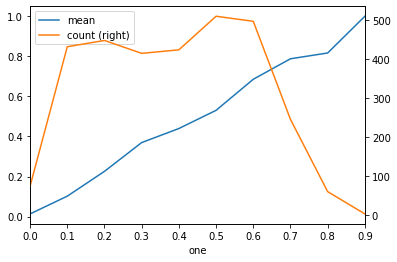

In [408]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [409]:
df_res_grouped

,mean,count
one,,
0.0,0.013514,74
0.1,0.102088,431
0.2,0.225951,447
0.3,0.369565,414
0.4,0.439716,423
0.5,0.530452,509
0.6,0.685484,496
0.7,0.787755,245
0.8,0.816667,60


### Prediction

#### Categorical

In [170]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

In [171]:
eval_data.groupby('target').mean()

,diff_OPEN_CLOSE,diff_LOW_HIGH,chng_CLOSE,chng_HIGH,roll2m_chng_HIGH,roll2m_chng_CLOSE,roll20m_comp_CLOSE_OPEN,roll3m_chng_CLOSE,roll5m_chng_HIGH,chng_LOW,...,roll3m_diff_LOW_HIGH,roll20m_chng_HIGH,roll10m_diff_VOL,roll10m_comp_CLOSE_HIGH_1,roll2m_diff_VOL,roll10m_move_strength_abs,roll5m_chng_LOW,roll2m_chng_VOL,roll5m_chng_OPEN,pred_class
target,,,,,,,,,,,,,,,,,,,,,
0.0,0.016257,0.053545,-1.959965,-2.631510,-1.370651,-1.536737,0.493615,-0.992876,-0.504998,-2.049863,...,0.055629,-0.217809,477.258844,0.735812,509.067518,2494.372814,-0.482579,509.067518,-0.284464,0.198070
1.0,-0.013778,0.057046,2.672820,3.575496,1.969324,2.106416,0.460269,1.395237,0.685571,2.743437,...,0.052941,0.030395,354.328308,0.661165,337.798556,1830.658131,0.584705,337.798556,0.400488,0.556385


In [172]:
eval_data.groupby('pred_class').mean()

,diff_OPEN_CLOSE,diff_LOW_HIGH,chng_CLOSE,chng_HIGH,roll2m_chng_HIGH,roll2m_chng_CLOSE,roll20m_comp_CLOSE_OPEN,roll3m_chng_CLOSE,roll5m_chng_HIGH,chng_LOW,...,roll3m_diff_LOW_HIGH,roll20m_chng_HIGH,roll10m_diff_VOL,roll10m_comp_CLOSE_HIGH_1,roll2m_diff_VOL,roll10m_move_strength_abs,roll5m_chng_LOW,roll2m_chng_VOL,roll5m_chng_OPEN,target
pred_class,,,,,,,,,,,,,,,,,,,,,
0.0,0.005928,0.057401,-0.407265,-1.286976,-0.995637,-1.088214,0.489786,-0.747807,-0.406365,-1.183938,...,0.056968,-0.217359,542.502041,0.725511,515.100404,2760.847586,-0.463000,515.100404,-0.364194,0.295964
1.0,-0.001557,0.050756,0.861818,2.498931,2.029324,2.099456,0.459826,1.480459,0.771250,2.228307,...,0.049882,0.085153,207.106117,0.663346,288.375432,1193.158163,0.787804,288.375432,0.700150,0.680987


#### Prediction for couple of papers

In [410]:
res_cols = ['TICKER', 'OPEN', 'LOW', 'HIGH','CLOSE', 'prob_newHIGH']

res = pd.DataFrame(columns=res_cols)

In [411]:
for p in tqdm(skaner_df_see.ticker):
    df = prepare_data(p)
    df = transform_one_paper_ch(df)

    df.loc[:,'pred_class'] = model.predict(df[train_cols])
    df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

    one_res = df.loc[:,['TICKER','OPEN','LOW','HIGH', 'CLOSE', 'target', 'pred_class', 'pred_prob']].tail(1)

    res = pd.concat([res, pd.DataFrame([[one_res.values[0][0], 
                                   one_res.values[0][1],
                                   one_res.values[0][2],
                                   one_res.values[0][3],
                                   one_res.values[0][4],
                                   one_res.values[0][7]]], columns=res_cols)])

In [412]:
res.sort_values('prob_newHIGH')

,TICKER,OPEN,LOW,HIGH,CLOSE,prob_newHIGH
0,LUBAWA,1.260,1.100,1.370,1.1900,0.075490
0,TSGAMES,321.000,303.000,324.500,309.0000,0.089724
0,BIOMEDLUB,4.080,3.180,4.180,3.4900,0.113750
0,ZEPAK,7.320,7.320,7.560,7.3200,0.116944
0,LIVECHAT,46.900,45.400,46.900,45.8000,0.157017
0,CLNPHARMA,36.100,34.100,36.600,34.5000,0.185069
0,PCCEXOL,2.170,2.000,2.190,2.0300,0.195560
0,JWWINVEST,2.700,2.440,2.700,2.4700,0.211561
0,UNIMOT,20.350,19.580,20.350,20.0000,0.220106
0,SETANTA,7.500,7.000,7.500,7.3800,0.258209


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


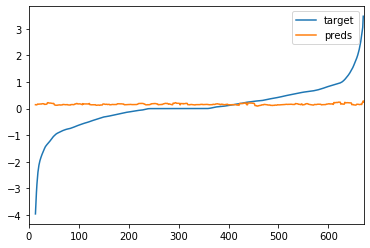

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

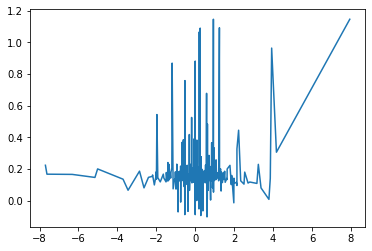

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

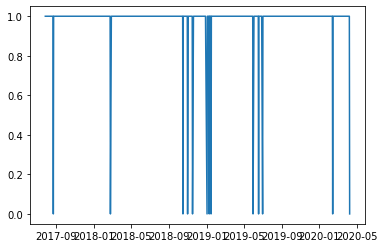

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
